In [58]:
# EDA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import save,load

# NLP stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

from gensim.models import Word2Vec
import gensim

# LSTM machine learning stuff etc
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Support
import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [59]:
#SETTINGS

#DATASET
TRAIN_SIZE = 0.8

#TEXT CLEANING REGEX 
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Importing Data

In [60]:
df = pd.read_csv("IMDB Dataset.csv")

### Exploring the Data


In [61]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [62]:
df.shape

(50000, 2)

In [63]:
df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

### Checking for null inputs

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### Distribution of Labels

In [65]:
sentiment_cnt = Counter(df.sentiment)

sentiment_cnt

Counter({'positive': 25000, 'negative': 25000})

### Preprocessing Text

In this section, we pre-process the reviews before feeding the text data into the models. We will perform the following processes:

1. Remove "@" usernames, URLs, and non-alphanumeric characters.

2. Remove stop-words.

3. Stem words to reduce words to their root form.

In [66]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

Previewing Stop-words

In [67]:
", ".join(stop_words) 

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [68]:
def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    return " ".join(tokens)

In [69]:
%%time
df.review = df.review.apply(lambda x:preprocess(x))

Wall time: 1min 52s


### Splitting Training and Testing Set

In [70]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=123)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 40000
TEST size: 10000


In [71]:
df_train

,review,sentiment
2660,ok first may spoiler sinc know constitut give ...,negative
32815,came new port south expect surrog movi columbi...,negative
35141,1st watch 8 7 2004 3 10 dir brett thompson sil...,negative
19390,first post imdb unfortun warn other wast time ...,negative
34846,movi man like blow gas contain br br also love...,negative
...,...,...
7763,movi sooooooo good hilari mani joke watch movi...,positive
15377,nifti littl movi demonstr rock solid virtu tim...,positive
17730,one moment film laugh mel brook one high point...,positive
28030,fan troma cyberpunk genr mix littl blood shed ...,positive


### Word2Vec Model

Word2vec models embed words in a lower-dimensional vector space using a shallow neural network. The result is a set of word-vectors where vectors close together in vector space have similar meanings based on context, and word-vectors distant to each other have differing meanings. 

Word2vec learns relationships between words automatically by converting words into vectors (one vector per word). These vectors display remarkable linear relationships. 

In [72]:
documents = [review.split() for review in df_train.review]

In [73]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [74]:
w2v_model.build_vocab(documents)

In [75]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

Wall time: 1min 55s


(142746893, 158605408)

In [76]:
w2v_model.wv.most_similar("enjoy")

[('fun', 0.5478349924087524),
 ('entertain', 0.5276791453361511),
 ('recommend', 0.5238512754440308),
 ('appreci', 0.49767619371414185),
 ('watch', 0.47226980328559875),
 ('disappoint', 0.42703479528427124),
 ('movi', 0.40579819679260254),
 ('think', 0.4036222994327545),
 ('worth', 0.3983020484447479),
 ('see', 0.38698461651802063)]

### Tokenize Text

Tokenizer() is a class from Tensorflow which allows the vectorising of text corpus, turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf etc.

In [77]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.review)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 63400
Wall time: 4.01 s


### Padding

In this section, we pad the sequences to the same length. We pad the text data to a maximum length of 300.

In [78]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train. review), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.review), maxlen=SEQUENCE_LENGTH)

Wall time: 3.72 s


### Label encoding

In this section, we encode our sentiments into labels, and reshape them for our model.

In [79]:
labels = df_train.sentiment.unique().tolist()
labels

['negative', 'positive']

In [80]:
encoder = LabelEncoder()
encoder.fit(df_train.sentiment.tolist())

y_train = encoder.transform(df_train.sentiment.tolist())
y_test = encoder.transform(df_test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


### Previewing shapes

In [81]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)

print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)
x_test (10000, 300)
y_test (10000, 1)


### Embedding Matrix

Identifying the words that appear in both Tokenizer and Word2Vec, and populating the embedding matrix based on the Word2Vec Embeddings

In [82]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(63400, 300)


### Model Building

Building a model with multiple layers including an Embedding layer, Convolutional layer, Maxpooling and LSTM.

In [83]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          19020000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 64)           96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 74, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 19,215,009
Trainable params: 195,009
Non-trainable params: 19,020,000
____________________________________

### Model Compilation

Model is compiled to optimise loss via adam to minimise binary crossentropy loss.

In [84]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Model Callbacks

We include callbacks to our model. We include the ReduceLROnPlateau to automatically adjust Learning Rate based on gradient, to allow for more effective convergence at local minima. We also include EarlyStopping to reduce overfitting.

In [85]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

### Model Training

We train the model using the following settings:

batch_size = 1024

epochs = 32

validation split = 0.1



In [86]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/32
36/36 [==============================] - 125s 3s/step - loss: 0.4699 - accuracy: 0.7660 - val_loss: 0.3341 - val_accuracy: 0.8540
Epoch 2/32
36/36 [==============================] - 123s 3s/step - loss: 0.3084 - accuracy: 0.8682 - val_loss: 0.3062 - val_accuracy: 0.8742
Epoch 3/32
36/36 [==============================] - 131s 4s/step - loss: 0.2732 - accuracy: 0.8866 - val_loss: 0.2933 - val_accuracy: 0.8785
Epoch 4/32
36/36 [==============================] - 134s 4s/step - loss: 0.2502 - accuracy: 0.8956 - val_loss: 0.2755 - val_accuracy: 0.8878
Epoch 5/32
36/36 [==============================] - 136s 4s/step - loss: 0.2364 - accuracy: 0.9022 - val_loss: 0.2654 - val_accuracy: 0.8888
Epoch 6/32
36/36 [==============================] - 138s 4s/step - loss: 0.2217 - accuracy: 0.9095 - val_loss: 0.2630 - val_accuracy: 0.8892
Epoch 7/32
36/36 [==============================] - 143s 4s/step - loss: 0.2068 - accuracy: 0.9170 - val_loss: 0.2903 - val_accuracy: 0.8810
Epoch 8/32
36

### Model Evaluation

We evaluate the model using the test set. We obtain an accuracy score of 0.9017

In [87]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 8s 758ms/step - loss: 0.2781 - accuracy: 0.9012

ACCURACY: 0.901199996471405
LOSS: 0.27808690071105957
Wall time: 7.77 s


### Plotting of Accuracy and Loss Graphs

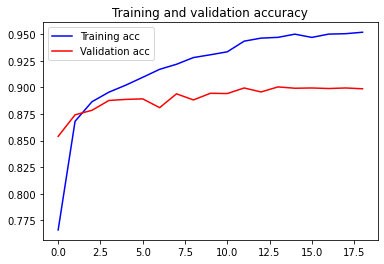

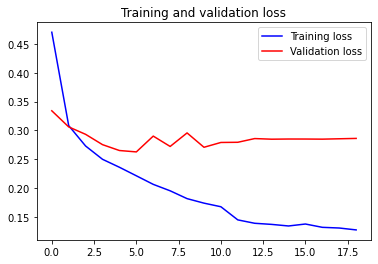

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Plotting Confusion Matrix

In [89]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [90]:
def decode_sentiment(score):
    return "negative" if score < 0.5 else "positive"

In [91]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.sentiment)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

2/2 [==============================] - 8s 2s/step
Wall time: 8.25 s


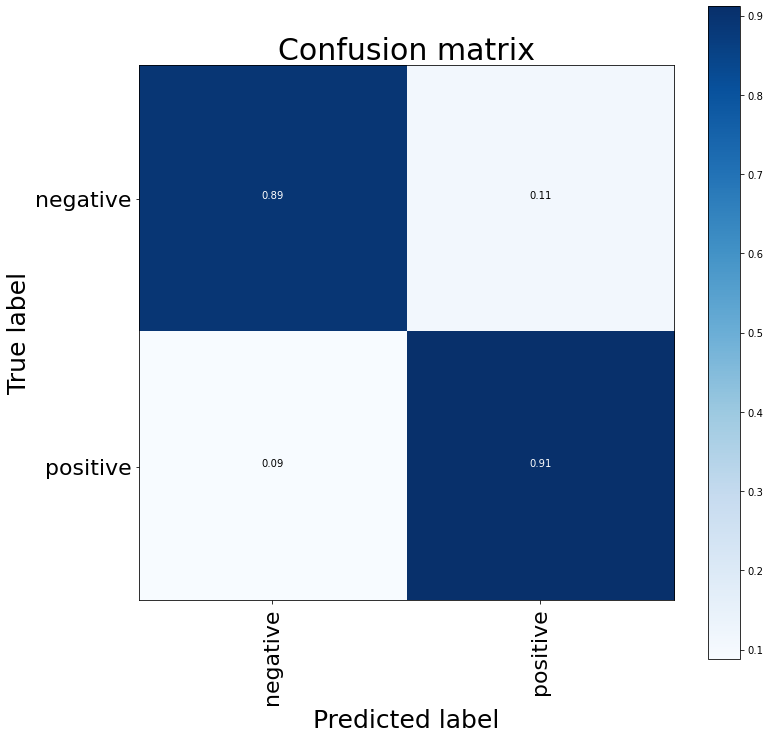

In [92]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.sentiment.unique(), title="Confusion matrix")
plt.show()

In [93]:
print(classification_report(y_test_1d, y_pred_1d))


              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      4979
    positive       0.89      0.91      0.90      5021

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [94]:
accuracy_score(y_test_1d, y_pred_1d)


0.9012

### Saving our models

In [95]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

### Predicting new text data

In [96]:
def predict(text):
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    score = model.predict([x_test])[0]
    label = decode_sentiment(score)
    return {"label": label, "score": float(score)}

In [97]:
predict("This movie was good!")

{'label': 'positive', 'score': 0.5918006300926208}

In [98]:
predict("This movie was very bad. So boring!")

{'label': 'negative', 'score': 0.13468340039253235}